# Wi-Fiパケットセンサによる観光客流動分析（白州地域を例に）

Wi-Fi観測データをもとに

- 季節別の訪問者の変化を調べてみる
- 地点間移動の特徴を分析する

「はくしゅう道の駅」は、8月～9月と、月以降はデータが欠損しているので、それ以外を主に使う。


(注） areaに"fuefuki", "kofu"などを指定すれば、笛吹や甲府の図の作成にも使える。（きちんと試してないが）


## 訪問数分析

Web上で閲覧できるサイト https://8tops.yamanashi.ac.jp/ff/ の地点（訪問者）データと同じような描画をpythonで行ってみる。

ファイルから直接データを読み込めるのだが、以下に示すプログラム例はWeb表示用に作ったものを流用しているので、サーバからjson形式で集計データを入手する仕組みになっている。


### 地点データ描画関数定義


In [42]:
json_root = "https://8tops.yamanashi.ac.jp/"

import json
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'  # 全体のフォントを設定
import numpy as np
from dateutil.relativedelta import relativedelta
import os
import csv

def plotHourlyData(points, day, addr='a', area='hakushu', out="", dev="all"):
    '''
    pointsで与えられた地点のdayで指定された１日のデータを表示する
    '''
    resp = requests.get(json_root + area + "/"
                        + "getHourlyCounts.php"
                        + "?sdate=" + day
                        + "&edate=" + day
                        + "&addr=" + addr
                        + "&dev=" + dev)
    json_dict = resp.json()
    plot_data = {}
    # プロットするデータをDataFrameに: 数値に変換する必要があることに注意
    pointAttrib = getPointAttribute(area)
    for pt in points:
        if not pt in json_dict.keys():
            continue
        plot_data[pointAttrib[pt]['短縮名']] = list(
            map(float, json_dict[pt][day]['hourly']))
    df4plot = pd.DataFrame(plot_data)

    # プロット
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax = df4plot.plot(ax=ax, fontsize=12)
    # 凡例は外側に固定
    ax.legend(fontsize=12, loc='center left',
              bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
    ax.set_title("地点アドレス数 (" + day + ")",
                 fontsize=12)
    ax.set_xlabel("時間", fontsize=12)
    ax.set_ylabel("アドレス数", fontsize=12)
    if out == "file":
        outfile_body = area + day
        plt.savefig(outfile_body + ".svg", bbox_inches="tight")
        import subprocess
        subprocess.run("inkscape --file " + outfile_body + ".svg"
                       + " --export-emf " + outfile_body + ".emf", shell=True)
    else:
        plt.show()

def plotDailyData(points, sday, eday, addr='a', area='hakushu', out="", dev="all"):
    """
    指定したエリア内のpointsのデータを作図
    points: 地点の単純なリスト
    """
    resp = requests.get(json_root + area + "/"
                        + "getHourlyCounts.php"
                        + "?sdate=" + sday
                        + "&edate=" + eday
                        + "&addr=" + addr
                        + "&dev=" + dev)
    json_dict = resp.json()
    plot_data = {}
    pointAttrib = getPointAttribute(area)

    for pt in json_dict:
        if not pt in points:
            continue
        plot_data[pointAttrib[pt]['短縮名']] = {}
        for day in json_dict[pt]:
            day_by_datetime = datetime.strptime(day, "%Y%m%d")
            plot_data[pointAttrib[pt]['短縮名']][day_by_datetime] = 0
            for h in json_dict[pt][day]['hourly']:
                plot_data[pointAttrib[pt]['短縮名']][day_by_datetime] += int(h)
    df4plot = pd.DataFrame(plot_data)
    # プロット
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax = df4plot.plot(ax=ax, fontsize=12)
    # 凡例は外側に固定
    ax.legend(fontsize=12, loc='center left',
              bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
    ax.set_title("地点アドレス数 (" + sday + "〜" + eday + ")",
                 fontsize=12)
    ax.set_xlabel("日", fontsize=12)
    ax.set_ylabel("アドレス数", fontsize=12)
    if out == "file":
        outfile_body = "kofu" + sday
        plt.savefig(outfile_body + ".svg", bbox_inches="tight")
        import subprocess
        subprocess.run("inkscape --file " + outfile_body + ".svg"
                       + " --export-emf " + outfile_body + ".emf", shell=True)
    else:
        plt.show()

def getPointAttribute(area): # センサ設置場所のプロパティをゲット
    filename = {"kofu": "/var/www/html/kofu/kofu_position.csv",
                "ff": "/var/www/html/ff/sensor_points.csv",
                "hakushu": "/home/toyoki/public_html/hakushu/points_hakushu.csv",
                "ttri": "/home/toyotamngr/csv/toyota/sensor_points.csv"}
    df = pd.read_csv(filename[area])
    return df.set_index('センサ名').T.to_dict()


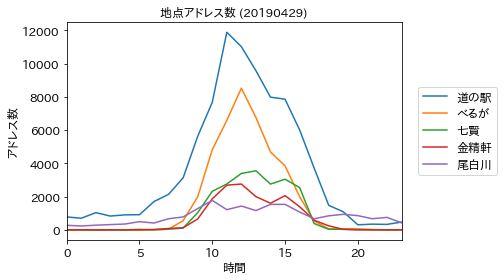

In [43]:
# 1日の訪問者データ表示例
points=['hakushu-rs', 'verga1', 'varga2', 'varga3', '7ken', 'kinsei', 'ojiro']
plotHourlyData(points, day="20190429", area="hakushu")

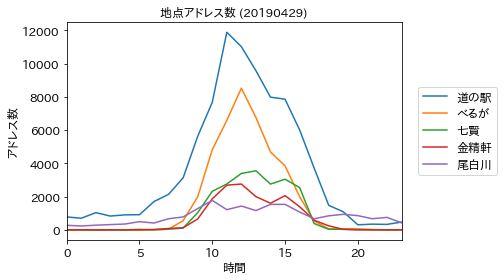

In [44]:
# out="file"とすると、図はsvg及びemf形式で、ノートブックと同じフォルダに保存される
plotHourlyData(points, day="20190429", area="hakushu", out="file")

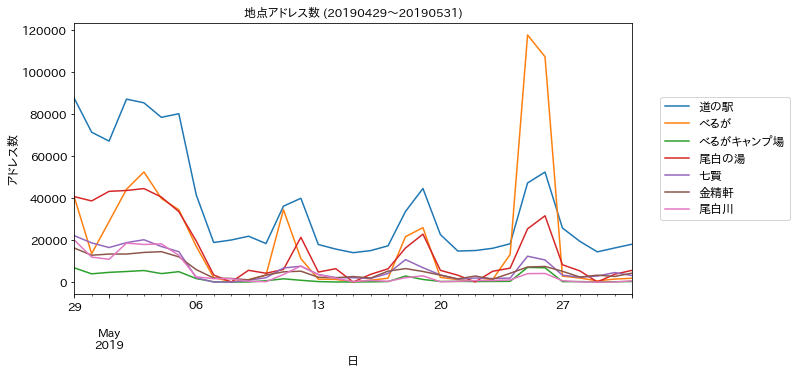

In [45]:
# ある期間の変化の表示例
points=['hakushu-rs', 'verga1', 'verga2', 'verga3', '7ken', 'kinsei', 'ojiro']
plotDailyData(points, sday="20190429", eday="20190531")

## 2地点間流動の図示

図示したい地点ペアと集計範囲の年月日を指定して作図する関数(plot_hourly_flow)を定義し、実行するサンプルを以下に示す。

地図城辺描画やサンキ(Sankey)図はWebサイトを参照のこと。

### 描画関数定義

In [18]:
# 流動プロット用関数定義
# データはデータベースに格納されている

# DB接続
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

font_size =20
fig_size = (14,7)

# 8tops上でのファイル (ファイル名は環境に応じて変更すること)
conn = sqlite3.connect("/home/raspimngr/db/hakushu_traveler.sqlite3")
#conn = sqlite3.connect("kofu_traveler.sqlite3")
cur = conn.cursor()

# テーブル名 (flow, flow_trunc10, flow_all_trunc, flow_all, flow_all_trunc10のどれか)
table_name = "flow_all_trunc10"


# 時間帯別流動数

def plot_hourly_flow(path, sub_title="", filename_body="temp", image_type="", direction=False,
                     sdate="2019-09-01", edate="2019-12-31", legend_outside=False):
    count_data = {"00": {}, "01":{},"02": {},"03": {},"04": {},"05": {},"06": {},"07": {},"08": {},"09": {},
                 "10": {},"11": {},"12": {},"13": {},"14": {},"15": {},"16": {},"17": {},"18": {},"19": {},
                 "20": {},"21": {},"22": {},"23": {}}
    opt_direction = ""
    for l, pos in path.items():
        if direction:
            opt_direction = ''
        else:
            opt_direction = ' or (origin="' + pos[1] + '" and destination="' + pos[0] + '")'
        
        sql = ("select hour, sum(number) from " + table_name 
               + ' where ((origin="' + pos[0] + '" and destination="' + pos[1] + '")'
               + opt_direction + ")"
               + ' and yearday>="' + sdate + '" and yearday<="' + edate+'" '
               + ' group by hour order by hour')
        result = cur.execute(sql).fetchall()
        for v in result:
            count_data[v[0]][l] = v[1]
    df = pd.DataFrame.from_dict(count_data)
    df = df.T
    df = df.reset_index()
    
    fig = plt.figure( figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    ax = df.plot(ax=ax, fontsize=font_size, xticks=df.index, lw=3)
    if legend_outside:
        ax.legend(fontsize=font_size,loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.legend(fontsize=font_size)
    ax.set_title("時間別移動アドレス数"+sub_title + "  "+ sdate + " ～ " + edate, fontsize=font_size)
    ax.set_xlabel("時間", fontsize=font_size)
    ax.set_ylabel("アドレス数", fontsize=font_size)
    
    if image_type !="":
        if image_type=="emf": # 出力形式がemf指定のときは、svgにセーブしてからinkscapeで変換
            plt.savefig(filename_body + sdate +"_" + edate + ".svg" , bbox_inches="tight")
            import subprocess
            subprocess.run("inkscape --file " + filename_body + ".svg"
                           + " --export-emf " + filename_body + ".emf", shell=True)
        else:
            plt.savefig(filename_body + "." + image_type, bbox_inches="tight")
    plt.show()
                     
def get_name_pairs(point_pairs, area="hakushu"):
    """
    [["12","22"], [ ], ... のような地点ペアを与えて、地点名をキーに入れて返す
    """
    filename = {"kofu": "/var/www/html/kofu/sensor_points.csv",
            "fuefuki": "/var/www/html/ff/sensor_points.csv",
            "hakushu": "/var/www/html/hakushu/sensor_points.csv",
            "ttri": "/home/toyotamngr/csv/toyota/sensor_points.csv"}
    
    df = pd.read_csv(filename[area])
    path = {}
    
    for p in  point_pairs:
        if area == "kofu":
            p0 = "kofu" + p[0]
            p1 = "kofu" + p[1]
        else:
            p0 = p[0]
            p1 = p[1]
        key = (df[df.センサ名 == p0]['短縮名'].values[0] + " → "
               + df[df.センサ名 == p1]['短縮名'].values[0])
        path[key] = [p[0], p[1]]
    return path

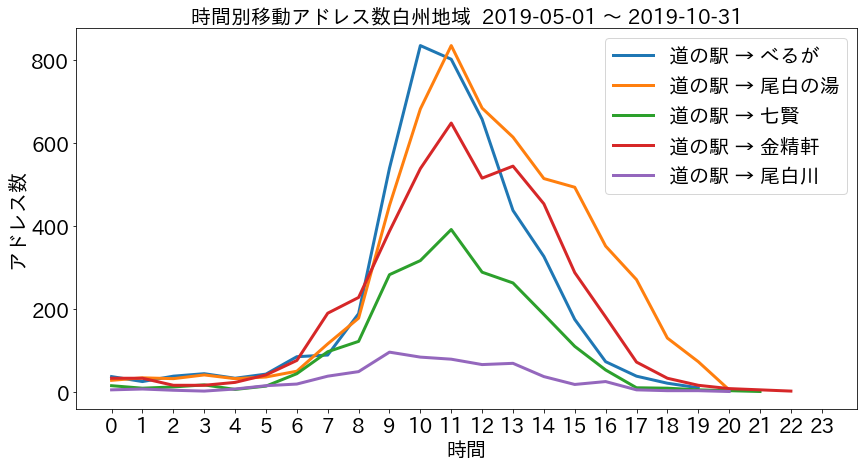

In [22]:
# 実行サンプル
# 白州全域
pairs = [["hakushu-rs", "verga1"], ["hakushu-rs", "verga3"], ["hakushu-rs", "7ken"],
         ["hakushu-rs","kinsei"],["hakushu-rs","ojiro"]] # 調べたい地点ペア
#pairs = [["verga1", "hakushu-rs"], ["verga3","hakushu-rs"], ["7ken", "hakushu-rs"],
#         ["kinsei", "hakushu-rs"],["ojiro", "hakushu-rs"]]
path = get_name_pairs(pairs)
plot_hourly_flow(path, "白州地域","HakushuFlowFromRS",
                 "emf", sdate="2019-05-01", edate="2019-10-31",
                 direction=True, legend_outside=False)

## 移動時間分布



## 付録

センサ一覧

In [2]:
import pandas as pd
filename = {"kofu": "/var/www/html/kofu/sensor_points.csv",
            "fuefuki": "/var/www/html/ff/sensor_points.csv",
            "hakushu": "/var/www/html/hakushu/sensor_points.csv",
            "ttri": "/home/toyotamngr/csv/toyota/sensor_points.csv"}
pd.read_csv(filename["hakushu"])

センサ名         緯度          経度       地点名 グループ       短縮名
0  hakushu-rs  35.810279  138.330937  道の駅はくしゅう   白州       道の駅
1      verga1  35.799773  138.313634     べるが受付   白州       べるが
2      verga2  35.800417  138.317067  べるがキャンプ場   白州  べるがキャンプ場
3      verga3  35.801683  138.315009      尾白の湯   白州      尾白の湯
4        7ken  35.807883  138.343002        七賢   白州        七賢
5      kinsei  35.807870  138.342497       金精軒   白州       金精軒
6       ojiro  35.794687  138.295624  尾白川キャンプ場   白州       尾白川